Kalman filter inspired models
-----------------------------

In [1]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Union, Optional, List, NamedTuple, Any
from torch import Tensor

In [2]:
import data
import util
import train
import eval_

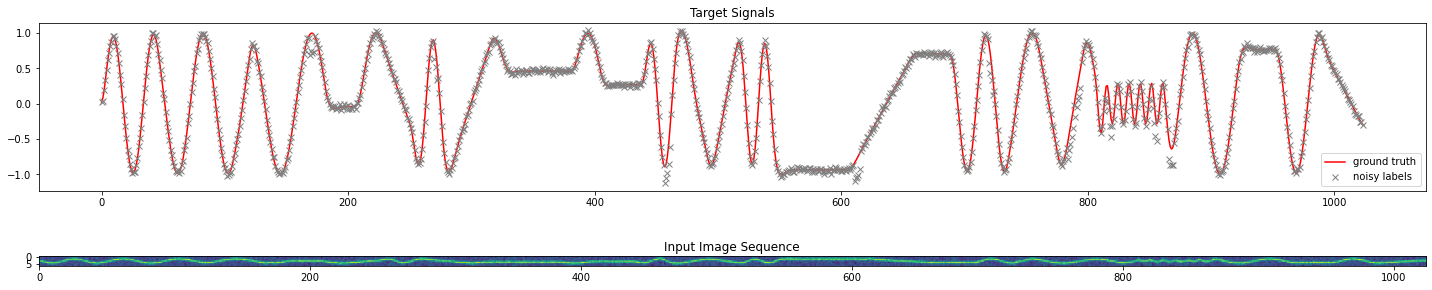

In [3]:
testdata = eval_.make_testset()

_ = data.plot_sequence(*testdata[0])
plt.tight_layout()

## Model

In [4]:
device = 'cuda'

In [5]:
from models import Out, Backbone


# Estimate of the state
class Estimate(NamedTuple):
    x : Tensor
    p : Tensor


class KalmanMotionModelOut(NamedTuple):
    # Like `Estimate` but the non-linear model needs a way to return the projection matrix, too.
    x : Tensor # State estimate vector
    p : Tensor # Covariance matrix
    h : Optional[Tensor] # State-to-measurement projection matrix


class ObservationModel(nn.Module):
    def __init__(self, output_size=1):
        super().__init__()
        self.output_size = output_size
        self.backbone = Backbone()
        self.fc = nn.Linear(self.backbone.num_features, 2*output_size)
 
    def forward(self, x : Tensor):
        L, B, C, W = x.shape
        x = self.backbone(x.view(L*B, C, W))
        x = self.fc(x)
        x = x.view(L, B, *x.shape[1:])
        return Out(x[...,None,:self.output_size], F.softplus(x[...,None,self.output_size:])+1.e-6)

    
class PhysicalMotionModel(nn.Module):
    '''
    Standard piecewise constant acceleration model
    '''
    def __init__(self):
        super().__init__()
    
    def create_initial_state(self, batchsize, device):
        x0 = torch.zeros(batchsize, 2, 1, device=device)
        p0 = torch.eye(2, device=device)[None,...].expand(batchsize,-1,-1)
        return KalmanMotionModelOut(x0, p0, None)
    
    def forward(self, x : Tensor, p : Tensor):
        '''
        State propagation to next timestep with linear model
        x[0] = position
        x[1] = velocity
        '''
        # See e.g. https://net.cs.uni-bonn.de/fileadmin/ag/koch/lehre/1617ws/SDF__Lecture_9_WS_16-17.pdf
        matrices = lambda w: torch.tensor(w, dtype=torch.float32, device=x.device)[None,...].expand(B,-1,-1)
        B = x.size(0)
        dt = 1.
        q = matrices([[0.25*dt**4, 0.5*dt**2], [0.5*dt**2, dt]]) # Process variance
        f = matrices([[1., dt], [0, 1.]]) # Transition matrix (acceleration = 1 (?))
        h = matrices([[1., 0.]]) # Extract position as "observation"
        x = f @ x
        p = f @ p @ f.mT + q
        return KalmanMotionModelOut(x, p, h)


def spdify(m):
    """
    Generate SPD matrices from arbitrary square input matrices.
    Note that the lower triangular part of the input is ignored.
    """
    m = torch.triu(m)
    d = torch.diagonal(m, dim1=-2,dim2=-1)
    d[...] = F.softplus(d[...].clone())
    return m @ m.mT

    
class NonlinearMotionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.state_features = 4
        self.hidden_features = 16
        n = self.state_features
        h = self.hidden_features
        self.layers = nn.Sequential(
            nn.Linear(n, h, bias=False),
            nn.LayerNorm([h]),
            nn.SiLU(inplace=True))
        self.fc_f = nn.Linear(h, n*n)
        self.fc_h = nn.Linear(h, n)
        self.q = nn.Parameter(torch.randn(n, n)*0.01)
    
    def create_initial_state(self, batchsize, device):
        x0 = torch.zeros(batchsize, self.state_features, 1, device=device)
        p0 = torch.eye(self.state_features, device=device)[None,...].expand(batchsize,-1,-1)
        return Estimate(x0, p0)
    
    def forward(self, x : Tensor, p : Tensor):
        B = x.size(0)
        y = x.view(B,-1)
        y = self.layers(y)
        n = self.state_features
        f = torch.triu(self.fc_f(y).view(B,n,n))
        q = spdify(self.q).expand(B,-1,-1)
        h = F.softplus(self.fc_h(y).view(B,1,n))
        x = f @ x
        p = f @ p @ f.mT + q
        return KalmanMotionModelOut(x, p, h)
    
    
def kalman_update(x, p, h, o, r):
    K = p @ h.mT @ torch.linalg.inv(h @ p @ h.mT + r)
    x = x + K @ (o - h @ x)
    I = torch.eye(x.size(-2), dtype=torch.float32, device=device).expand(x.size(0),-1,-1)
    p = (I - K @ h) @ p
    return x, p

def kalman_project_to_observation(x, p, h):
    return (h @ x), (h @ p @ h.mT)



def test_observation_model():
    bs = 128
    model = ObservationModel(1)
    x = model(torch.rand(3, bs, 1, 7))
    assert x.r.shape == (3, bs, 1, 1)


def _test_motionmodel1():
    B = 3
    m = PhysicalMotionModel()
    s = m.create_initial_state(B, device)
    x, p, h = m(s.x, s.p)
    
    # Measurement and noise
    o = torch.ones((B, 1, 1), dtype=torch.float32, device=device)
    r = torch.full((B,1,1), 1., dtype=torch.float32, device=device)

    # Not exactly a good test. If this runs without error and the results look good it's probably bug free
    kalman_update(x, p, h, o, r)
   
    # Measurement and noise
    o = torch.ones((B, 1, 1), dtype=torch.float32, device=device)
    r = torch.full((B,1,1), 1., dtype=torch.float32, device=device)

    kalman_update(x, p, h, o, r)


def _test_motionmodel2():
    B = 3
    m = NonlinearMotionModel().to(device)
    s = m.create_initial_state(B, device)
    x, p, h = m(s.x, s.p)
    
    # Measurement and noise
    o = torch.ones((B, 1, 1), dtype=torch.float32, device=device)
    r = torch.full((B,1,1), 1., dtype=torch.float32, device=device)

    kalman_update(x, p, h, o, r)
    
    
def _test_spdify():
    a = spdify(torch.rand(1,1,3,3))
    assert torch.linalg.cholesky(a) is not None

_test_spdify()
_test_motionmodel1()
_test_motionmodel2()
test_observation_model()

In [6]:
class KfModel(nn.Module):
    '''
    The Kalman Filter Implementation
    '''
    def __init__(self, MotionModelClass):
        '''
        MotionModelClass is the type / factory to construct the motion model
        '''
        super().__init__()
        self.motionmodel = MotionModelClass()
        self.observationmodel = ObservationModel(1)

    @property
    def device(self):
        return next(self.parameters()).device
        
    def create_initial_state(self, batchsize):
        s = self.motionmodel.create_initial_state(batchsize, self.device)
        return s

    def forward(self, visuals : Tensor, state : Estimate):
        L, B, C, W = visuals.shape
        out_x, out_p, out_expected_o, out_expected_r = [], [], [], []
        os, rs = self.observationmodel(visuals)
        for o, r in zip(os, rs):
            pred = self.motionmodel(state.x, state.p)
            #print (x_pred.shape, p_pred.shape, h.shape, o.shape, r.shape)
            x, p = kalman_update(pred.x, pred.p, pred.h, o, r)
            out_x.append(x)
            out_p.append(p)
            o, r = kalman_project_to_observation(x, p, pred.h)
            state = Estimate(x, p)
            out_expected_o.append(o)
            out_expected_r.append(r)
        out_x = torch.stack(out_x, dim=0)
        out_p = torch.stack(out_p, dim=0)
        out_expected_o = torch.stack(out_expected_o, dim=0)[...,0] # Removed matrix columns dimension
        out_expected_r = torch.stack(out_expected_r, dim=0)
        return Out(out_expected_o, out_expected_r), state

In [7]:
def test_kf():
    L = 64
    B = 42
    W = 7
    model = KfModel(PhysicalMotionModel).to(device)
    model.train()
    print ("Num Parameters: ", sum([p.numel() for p in model.parameters()]))
    seqs = torch.zeros((L, B,1,W), device=device)
    out, state = model(
        seqs,
        model.create_initial_state(B)
    )
    # Good enough to catch the worst errors ..
    assert (out.y.shape[0] == L)
    assert (out.r.shape[0] == L)

test_kf()

Num Parameters:  2122


In [8]:
from models import SingleFrameRegression

## Training

In [9]:
num_samples = 8 * 1024 * 1024
learning_rate = 0.01

## Testing

In [10]:
sfmodel = SingleFrameRegression().to(device)
train.train_singleframe_model(sfmodel, 4096, num_samples, learning_rate)

Loss: 0.00368: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:08<00:00, 238.41it/s]


In [11]:
kfmodel = KfModel(NonlinearMotionModel).to(device)
train.train_sequence_model(kfmodel, 1024, 32, num_samples, learning_rate, None, None)

Loss: 0.00425, Smoothness nan: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:24<00:00, 10.43it/s]


In [12]:
kfmodel_smooth_A = KfModel(NonlinearMotionModel).to(device)
train.train_sequence_model(kfmodel_smooth_A, 1024, 32, num_samples, learning_rate, 5., train.Smooth2ndDerivLoss().to(device))

Loss: 0.00794, Smoothness 0.00192: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:23<00:00, 10.70it/s]


In [13]:
kfmodel_smooth_B = KfModel(NonlinearMotionModel).to(device)
train.train_sequence_model(kfmodel_smooth_B, 1024, 32, num_samples, learning_rate, 5., train.RobustSmooth2ndDerivLoss(eps=0.1).to(device))


Loss: 0.00409, Smoothness 0.00043: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:23<00:00, 10.90it/s]


In [14]:
kfmodel_physical = KfModel(PhysicalMotionModel).to(device)
train.train_sequence_model(kfmodel_physical, 1024, 32, num_samples, learning_rate, 5., train.Smooth2ndDerivLoss().to(device))

Loss: 0.00929, Smoothness 0.00636: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:19<00:00, 13.15it/s]


sfmodel


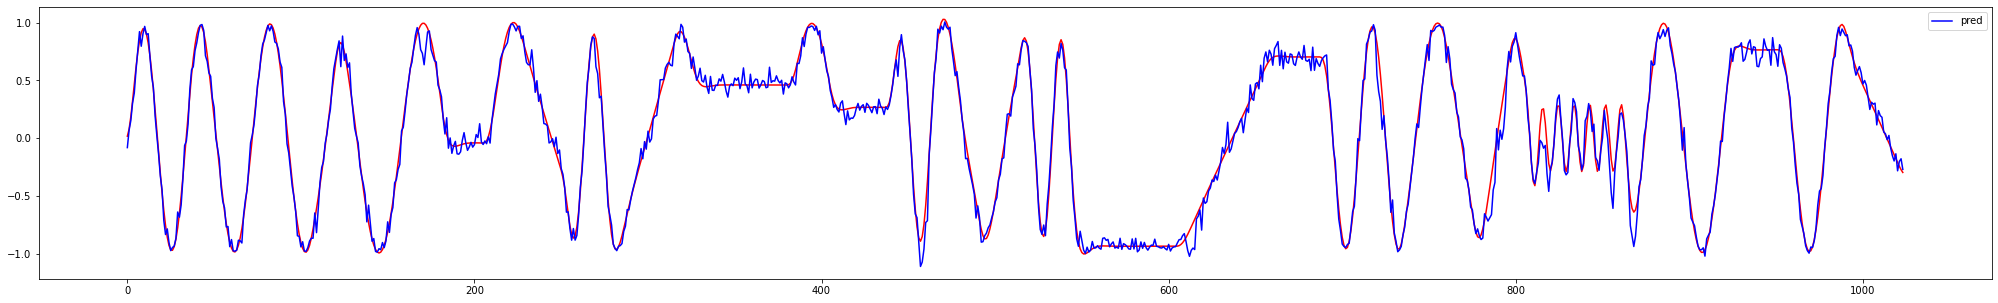

kfmodel


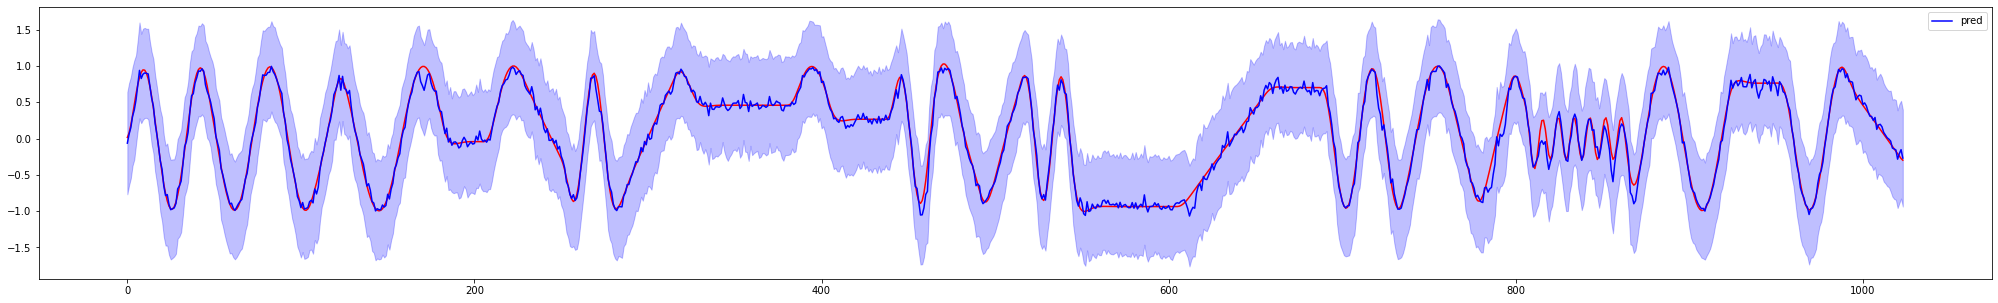

kfmodel_smooth_A


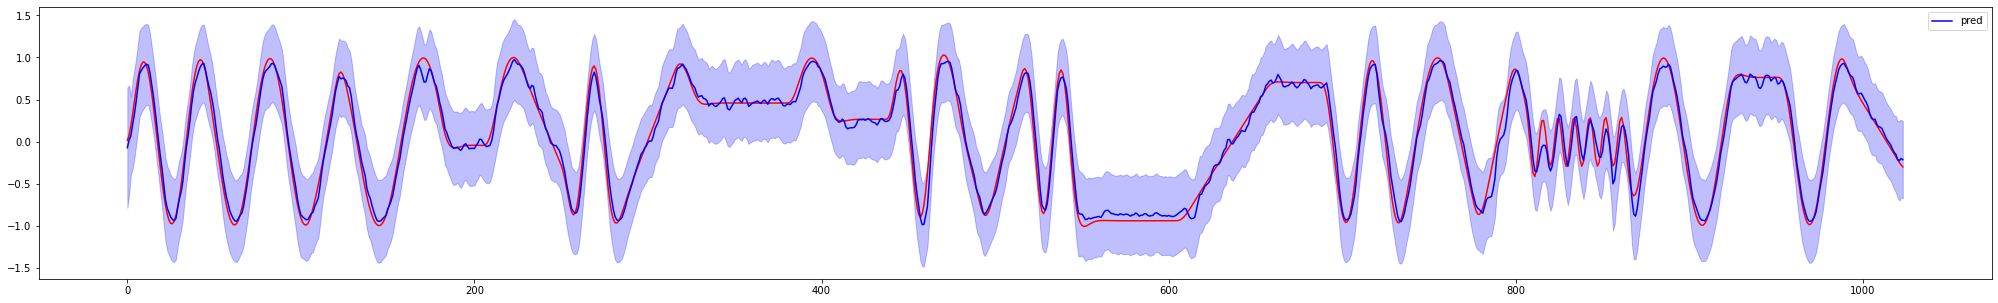

kfmodel_smooth_B


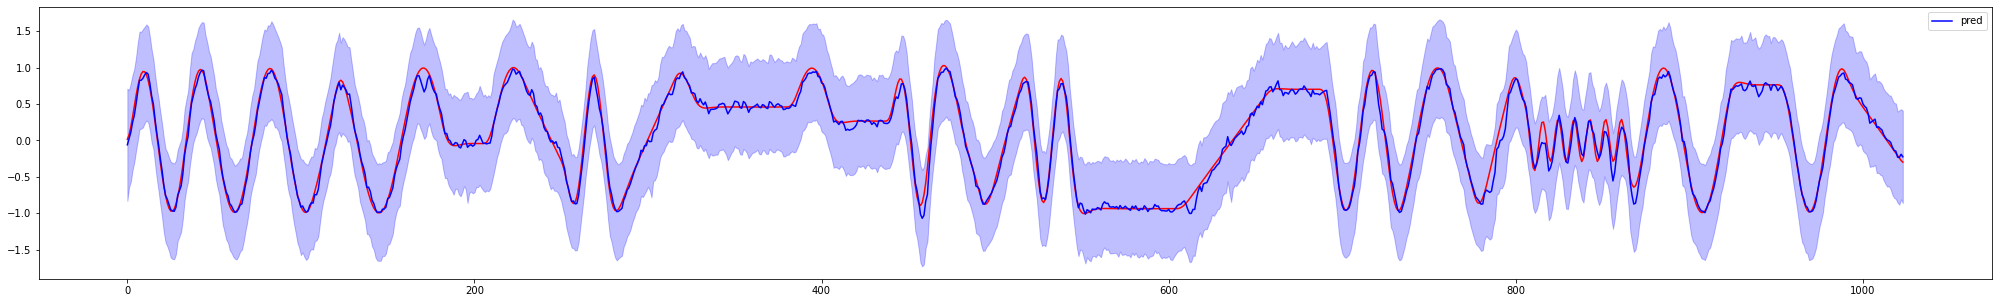

kfmodel_physical


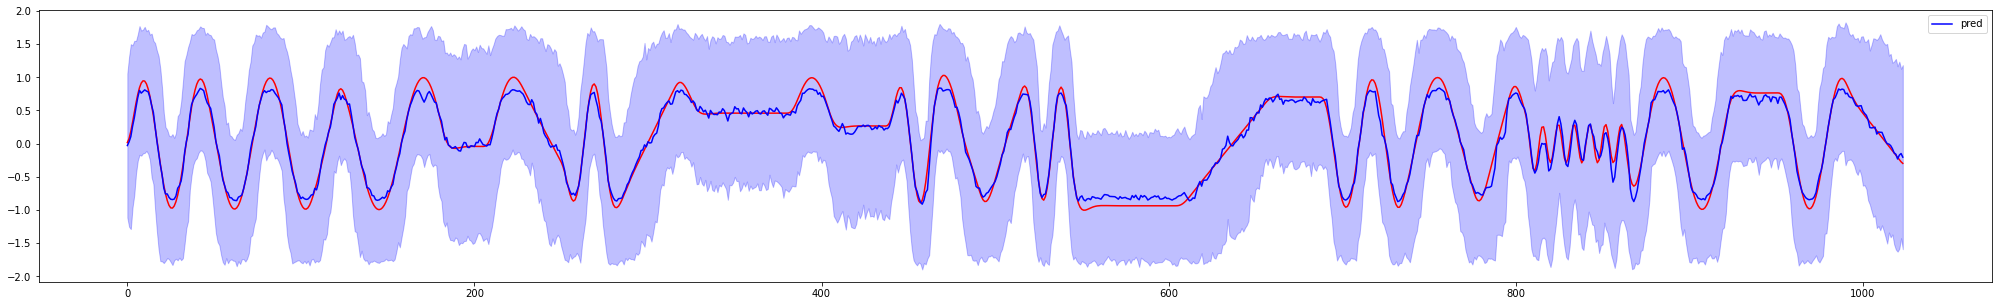

In [15]:
print('sfmodel'); eval_.evaluate(sfmodel, testdata)
print('kfmodel'); eval_.evaluate(kfmodel, testdata)
print ('kfmodel_smooth_A'); eval_.evaluate(kfmodel_smooth_A, testdata)
print ('kfmodel_smooth_B'); eval_.evaluate(kfmodel_smooth_B, testdata)
print ('kfmodel_physical'); eval_.evaluate(kfmodel_physical, testdata)